This notebook defines and fits a k-means classifier to the 8-band raster stack for the Southeast area of interest. It also calculates accuracy scores for the entire data set and a flood-only subset. 

In [1]:
# Import packages
import os
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
import pandas as pd
from glob import glob
import rasterio as rio
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy as et
from skimage import measure
from skimage import morphology
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
# Define area of interest directory 
aoi = "southeast_ps"

# Set input and output paths
kmeans_filename = "southeast_kmeans_all_bands"
band_path = '..\\data\\'+aoi+"\\"
raster_outputs_path = os.path.join(band_path, "final_outputs\\raster_files\\")
kmeans_outputs_path = os.path.join(band_path, "final_outputs\\kmeans\\")
try:
    os.makedirs(kmeans_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")
kmeans_path = os.path.join(kmeans_outputs_path+kmeans_filename+".tif")


# Import validation reference point shape files
validation_data_path = os.path.join(band_path, 'validation\\')
sample_pts = gpd.read_file(
    validation_data_path+"vector-data\\additional_val_points_southeast.shp")
valid_data = pd.read_csv(validation_data_path +
                         "additional_val_points_southeast.csv")

band_path directory already exists!


In [3]:
# Create raster stack of all bands
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()
all_bands_path = os.path.join(raster_outputs_path, aoi + "_all_bands.tif")
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                     all_bands_path)

# Open raster stack and make copies of meta file for use in writing out files later
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
files_out_meta['count'] = 1

In [4]:
# Define k-means classifier
nclass = 7
clf_kmeans = KMeans(n_clusters=nclass, random_state=10)

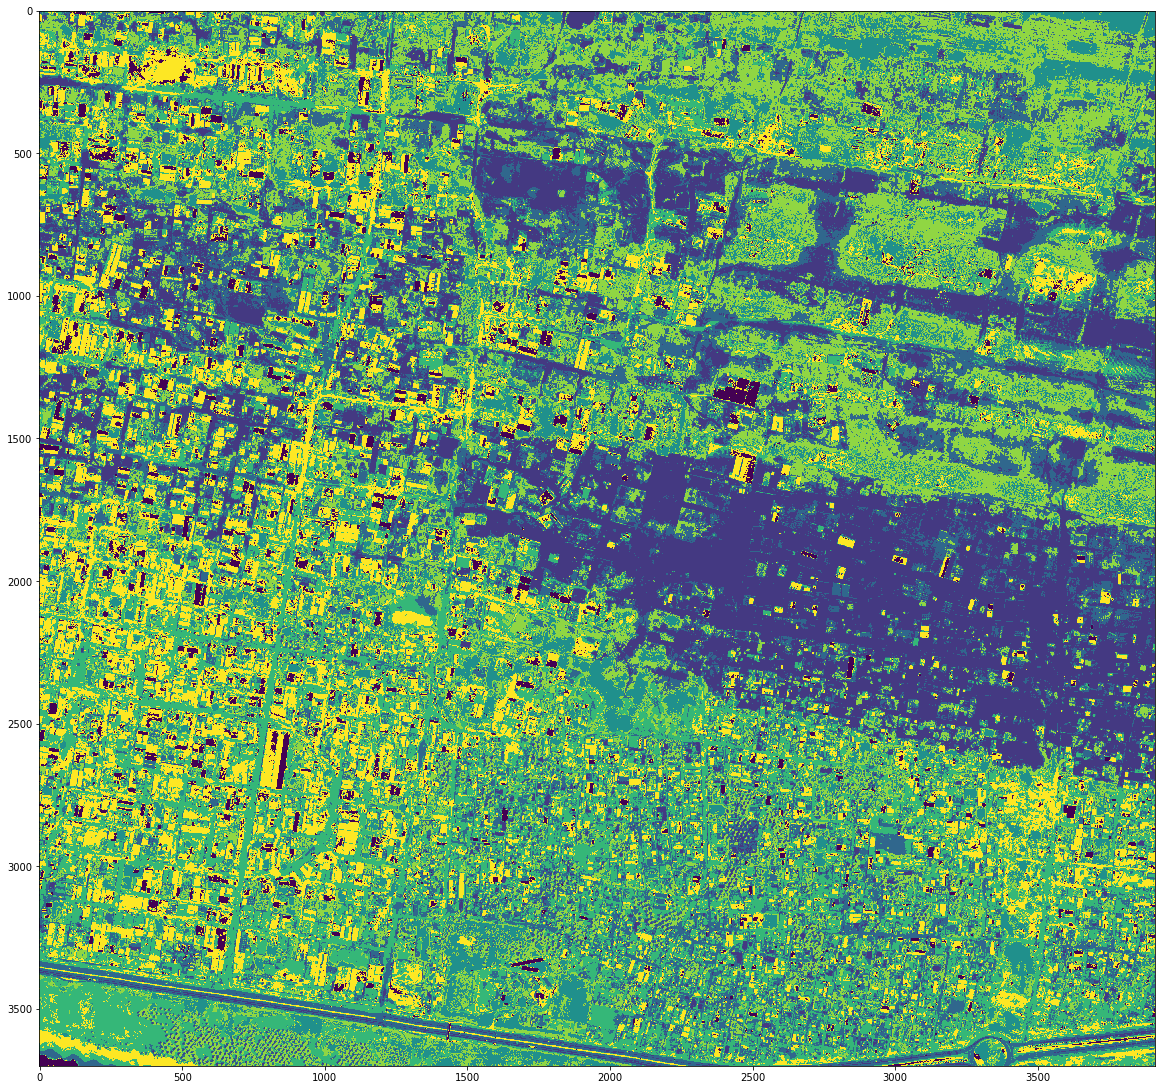

In [6]:
# Fit the KMeans classifier to the 8-band raster stack
all_bands_im = np.rollaxis(all_bands_stack, 0, 3)
X_all_bands_stack = all_bands_im.reshape(-1, 8)
predictedClass_all_bands = clf_kmeans.fit_predict(X_all_bands_stack, y=None)
predictedClass_all_bands += 1

# Plot the result
fig, ax = plt.subplots(figsize=(20, 20))
pred_data_all_bands = predictedClass_all_bands.reshape(all_bands_im.shape[:2])
ax.imshow(pred_data_all_bands)
plt.show()

# Write out the resulting k-means map
with rio.open(kmeans_outputs_path+kmeans_filename+'.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_all_bands.astype('float32'), 1)

In [7]:
# Update classes after looking at what each cluster represents
# 1 = shadow, 2 = flood, 3 = other
class7 = 4
class6 = 3
class5 = 4
class4 = 3
class3 = 2  # This cluster contains both shadow and flood
class2 = 2
class1 = 4
class0 = 0

## Validating on complete reference dataset

In [8]:
# Create tuples of all x coordinates and y coordinates
x_coords = tuple(sample_pts.geometry.x)
y_coords = tuple(sample_pts.geometry.y)

# Use rasterio sample method to pull data numbers from reference dataset.
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_path) as src:
    #     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):

        # Note that each val is an individual numpy array
        sampled_values.append(val)

# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
kmeans_all_df = pd.DataFrame(arr)

In [12]:
# Combine reference data with kmeans clusters
kmeans_valid_all = pd.concat([valid_data, kmeans_all_df], axis=1, sort=False)
kmeans_valid_all.columns = ["OBJECTID", "ClassValue", "Kmeans_Cluster"]
kmeans_valid_all.head()

,OBJECTID,ClassValue,Kmeans_Cluster
0,1,2,5.0
1,2,2,5.0
2,3,2,3.0
3,4,2,5.0
4,5,2,5.0


In [10]:
# Assign predicted class values based on k-means cluster
classid = [class0, class1, class2, class3, class4, class5, class6, class7]

for i in range(1, 8):
    kmeans_valid_all.loc[kmeans_valid_all['Kmeans_Cluster']
                         == i, "Kmeans_ClassValue"] = classid[i]
kmeans_valid_all.head()

,OBJECTID,ClassValue,Kmeans_Cluster,Kmeans_ClassValue
0,1,2,5.0,4.0
1,2,2,5.0,4.0
2,3,2,3.0,2.0
3,4,2,5.0,4.0
4,5,2,5.0,4.0


In [14]:
# Calculate accuracy score for k-means results
ytest = kmeans_valid_all['ClassValue']
ypred = kmeans_valid_all['Kmeans_ClassValue']
accuracy_score(ytest, ypred)

0.7816393442622951

[[  0 252   0   0]
 [  0 408   0  19]
 [  0  19 406   0]
 [  0  43   0 378]]


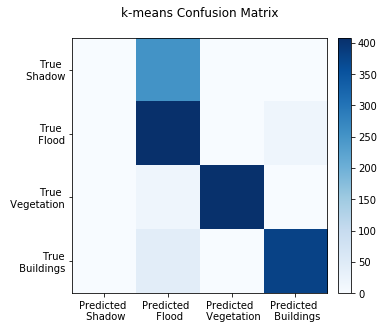

In [15]:
# Plot confusion matrix for k-means results
conf_matrix = confusion_matrix(ytest, ypred)
conf_matrix = conf_matrix[0:4, 0:4]
print(conf_matrix)
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 'Predicted \n Vegetation', 'Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 'True \n Flood', 'True \n Vegetation', 'True\n Buildings'])
conf_mat = ax.imshow(conf_matrix, cmap='Blues',
                     interpolation='nearest')
ax.set(title="k-means Confusion Matrix\n")
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
plt.show()

In [16]:
# Write out confusion matrix
confusion_all = confusion_matrix(ytest, ypred)
pd.DataFrame(confusion_all).to_csv(kmeans_outputs_path +
                                   'southeast_kmeans_all_bands_confusion_all_with_shadow.csv')

In [17]:
# Subset to focus only on flood, all other reference points (shadow, other) removed
flood_only_accuracy = kmeans_valid_all[kmeans_valid_all.ClassValue == 2]
flood_only_accuracy.head()

,OBJECTID,ClassValue,Kmeans_Cluster,Kmeans_ClassValue
0,1,2,5.0,4.0
1,2,2,5.0,4.0
2,3,2,3.0,2.0
3,4,2,5.0,4.0
4,5,2,5.0,4.0


In [18]:
# Calculate accuracy score for flood only subset
ytest_flood_only = flood_only_accuracy['ClassValue']
ypred_flood_only = flood_only_accuracy['Kmeans_ClassValue']
accuracy_score(ytest_flood_only, ypred_flood_only)

0.955503512880562

[[408  19]
 [  0   0]]


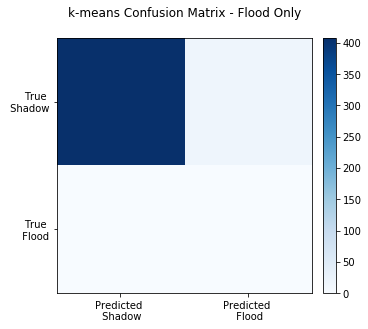

In [19]:
# Plot confusion matrix for k-means results
conf_matrix = confusion_matrix(ytest_flood_only, ypred_flood_only)
print(conf_matrix)
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 'Predicted \n Vegetation', 'Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 'True \n Flood', 'True \n Vegetation', 'True\n Buildings'])
conf_mat = ax.imshow(conf_matrix, cmap='Blues',
                     interpolation='nearest')
ax.set(title="k-means Confusion Matrix - Flood Only\n")
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
plt.show()